# Traffic Sign Recognition

This project is using the data from the [The German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)

    @inproceedings{Stallkamp-IJCNN-2011,
    author = {Johannes Stallkamp and Marc Schlipsing and Jan Salmen and Christian Igel},
    booktitle = {IEEE International Joint Conference on Neural Networks},
    title = {The {G}erman {T}raffic {S}ign {R}ecognition {B}enchmark: A multi-class classification competition},
    year = {2011},
    pages = {1453--1460}}

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
from random import shuffle
from tqdm import tqdm

import numpy as np
import tensorflow as tf

from readTrafficSigns import *
from utils import *

In [2]:
TRAIN_DATA_PATH = './GTSRB/Training'
TEST_DATA_PATH = './GTSRB/Test'
CLASSES_NUM = 43

In [3]:
images, labels = readTrafficSigns(TRAIN_DATA_PATH)

In [4]:
print ('Labels:',len(labels), '- Images:',len(images), '- Image shape:', images[100].shape)

Labels: 39209 - Images: 39209 - Image shape: (35, 36, 3)


y = 1


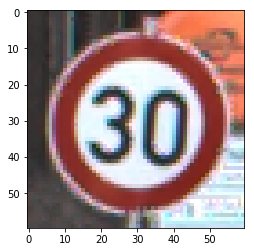

In [5]:
# Example of an image
index = 2000
plt.imshow(images[index])
print ("y = " + str(labels[index]))

### Convert labels to one hot array

In [6]:
labels = np.array(labels).astype(np.int) # String to Int Array

one_hot_labels = convert_to_one_hot(labels, CLASSES_NUM)
#targets = pd.Series(np.array(labels))
#one_hot = pd.get_dummies(targets, sparse = True)
#one_hot_labels = np.asarray(one_hot)

In [7]:
print(one_hot_labels.shape)

(39209, 43)


In [8]:
IMG_SIZE = 30 # image_size
LR= 1e-3 #learning rate
MODEL_NAME = 'Traffic_Signs-{}-{}.model'.format(LR,'2conv-basic')

In [9]:
def shuffle_resize_data():
    x_feature = []
    y_feature = []
    data = []
    #i = 0
    for index in tqdm(range(len(images))):
        label = one_hot_labels[index]
        gray_image = cv2.cvtColor(images[index], cv2.COLOR_BGR2GRAY)
        gray_resized_image = cv2.resize(gray_image, (IMG_SIZE,IMG_SIZE) ,interpolation = cv2.INTER_CUBIC)
        data.append([np.array(gray_resized_image), np.array(label)])
        #i +=1
    shuffle(data)
    np.save('data.npy',data)
    x_feature , y_feature = zip(*data) 
    return x_feature , y_feature

In [10]:
x_feature , y_feature = shuffle_resize_data()

100%|██████████| 39209/39209 [00:01<00:00, 38258.70it/s]


Y=  26


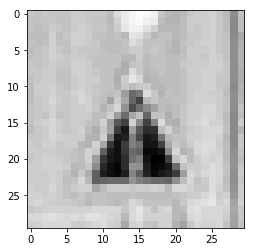

In [11]:
#Example of edited image
print("Y= ", np.argmax(y_feature[100]))
plt.imshow(x_feature[100], cmap=plt.cm.binary)
plt.show()

In [12]:
#train_data = np.Load('train_data.npy')

### Normalize the data

We need to normalize inputs like this: $$x_{norm} = \frac{x}{255} - 0.5$$

The data frames need to be the form of arrays and normolised. Becuase I'm dealing with grayscale here, I needed to add the dimension at the end of the array else it keras would raise an exception

In [13]:
# normalize the images
#x_train = tf.keras.utils.normalize(x_train)
#x_test = tf.keras.utils.normalize(x_test)

In [14]:
X_data = (np.array(x_feature, np.float32) / 255.)
print (X_data.shape)
X_data = np.expand_dims(X_data, axis = 3)
print (X_data.shape)

(39209, 30, 30)
(39209, 30, 30, 1)


In [15]:
Y_data = np.array(y_feature, np.uint8)
print (Y_data.shape)

(39209, 43)


### Split data to train and test
give 10% for test data from the total data

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.1)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 35289
number of test examples = 3920
X_train shape: (35289, 30, 30, 1)
X_test shape: (3920, 30, 30, 1)
Y_train shape: (35289, 43)
Y_test shape: (3920, 43)


# Building the Model

In [17]:
from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Convolution2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten

Using TensorFlow backend.



1. Convetional layer (detect features in image matrix)
2. Pooling layer (recongise features in different angle and/or size)
3. Convetional layer
4. Pooling laye
5. Flattening layer (flatten layers in array of imput)
6. Fully connected layer (fully connected ANN)
7. Output layer


In [21]:
def model(input_shape):
    model = Sequential()

    model.add(Convolution2D(filters = 64, kernel_size = (4,4),padding = 'Same', 
                             activation ='relu', input_shape = input_shape)) 

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Convolution2D(filters = 64, kernel_size = (4,4),padding = 'Same', 
                             activation ='relu')) 

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten()) 
    # fully connected NN 
    model.add(Dense(units = 43, activation = 'relu')) 
    # output layer
    model.add(Dense(units = 43, activation = 'softmax'))

    model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

    return model

In [22]:
tsr_model = model(X_train.shape[1:])
tsr_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1088      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        65600     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                134891    
_________________________________________________________________
dense_2 (Dense)              (None, 43)                1892      
Total para

### Fit the model into data

In [23]:
batch_size = 64 
nb_epochs = 10
history = tsr_model.fit(X_train, Y_train,
                        batch_size=batch_size,
                        epochs=nb_epochs,
                        verbose=2, 
                        validation_data=(X_test, Y_test),
                        initial_epoch=0)

Train on 35289 samples, validate on 3920 samples
Epoch 1/10
 - 140s - loss: 1.7314 - acc: 0.5465 - val_loss: 0.6394 - val_acc: 0.8202
Epoch 2/10
 - 140s - loss: 0.3754 - acc: 0.9006 - val_loss: 0.2443 - val_acc: 0.9395
Epoch 3/10
 - 136s - loss: 0.1814 - acc: 0.9544 - val_loss: 0.1848 - val_acc: 0.9528
Epoch 4/10
 - 132s - loss: 0.1139 - acc: 0.9718 - val_loss: 0.1770 - val_acc: 0.9480
Epoch 5/10
 - 131s - loss: 0.0781 - acc: 0.9806 - val_loss: 0.1037 - val_acc: 0.9747
Epoch 6/10
 - 132s - loss: 0.0602 - acc: 0.9855 - val_loss: 0.0869 - val_acc: 0.9806
Epoch 7/10
 - 130s - loss: 0.0479 - acc: 0.9878 - val_loss: 0.0882 - val_acc: 0.9806
Epoch 8/10
 - 129s - loss: 0.0364 - acc: 0.9912 - val_loss: 0.0724 - val_acc: 0.9849
Epoch 9/10
 - 141s - loss: 0.0259 - acc: 0.9939 - val_loss: 0.0686 - val_acc: 0.9849
Epoch 10/10
 - 174s - loss: 0.0270 - acc: 0.9932 - val_loss: 0.1045 - val_acc: 0.9730


In [80]:
#val_loss, val_acc = model.evaluate(x_test,y_test)

In [27]:
tsr_model.save('10epoch_10val_NoMean_2conv.model')

# Make some predictions

#### Load model if you have no one yet

In [9]:
tsr_model = tf.keras.models.load_model('10epoch_10val_NoMean_2conv.model')

In [67]:
# read one image for each class to display the result
class_image, class_label = readSingleTrafficSigns(TRAIN_DATA_PATH)
class_label = np.array(class_label).astype(np.int)

# read images for test
test_images_orig = readTestImages(TEST_DATA_PATH)
print(test_images_orig[0].shape)

(65, 70)


In [68]:
# Resize images
test_images = []

for index in tqdm(range(len(test_images_orig))):
    try:
        resized_image = cv2.resize(test_images_orig[index], (IMG_SIZE,IMG_SIZE) ,interpolation = cv2.INTER_CUBIC)
        test_images.append(resized_image)
    except: 
        pass

test_images = np.array(test_images, np.float32) / 255. # normalization
test_images = np.array(test_images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print("Test images shape: ", test_images.shape)

100%|██████████| 12631/12631 [00:00<00:00, 69121.42it/s]


Test images shape:  (12630, 30, 30, 1)


In [69]:
#predict
predictions = tsr_model.predict(test_images)

CLASS NO:  1


<function matplotlib.pyplot.show(*args, **kw)>

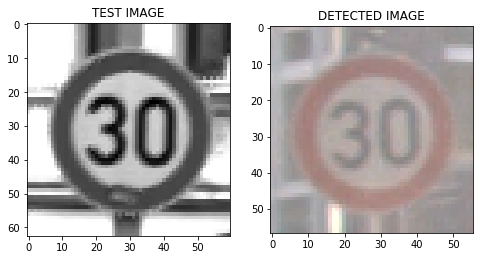

In [83]:
# Display result
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
plt.title('TEST IMAGE')
PRED_IMG = 1

plt.imshow(test_images_orig[PRED_IMG], cmap='gray')
plt.show

class_no = np.argmax(predictions[PRED_IMG])
print("CLASS NO: ", class_no)

fig.add_subplot(1, 2, 2)
plt.title('DETECTED IMAGE')
plt.imshow(class_image[class_label.tolist().index(class_no)], cmap='gray')
plt.show

In [72]:
predictions.shape

(12630, 43)

In [73]:
import pandas as pd
df =  pd.DataFrame(predictions)

In [74]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,3.610998e-32,2.958184e-23,8.753186e-09,1.471746e-09,1.193137e-30,2.345689e-12,1.802325e-37,1.329638e-11,1.648496e-22,5.970090e-23,...,6.239531e-32,0.000000e+00,1.607461e-36,6.335599e-29,1.976298e-22,7.989123e-27,5.557585e-24,1.122135e-18,1.839766e-37,6.033763e-23
1,3.394797e-08,9.999999e-01,6.276004e-10,5.697664e-20,6.667927e-21,1.264692e-08,3.501998e-08,5.901408e-25,1.851440e-21,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,4.764591e-35,0.000000e+00,5.520947e-30,0.000000e+00,1.487072e-22,4.074776e-37,1.129429e-21
2,6.979566e-13,2.591986e-09,5.739797e-07,9.998019e-01,5.880109e-17,1.973739e-04,6.164477e-09,2.492211e-11,2.966922e-11,9.424968e-12,...,3.140321e-23,2.427206e-17,2.643427e-16,8.883477e-11,6.060528e-21,9.477753e-08,3.769177e-19,2.740570e-11,2.872780e-13,7.873278e-12
3,1.652523e-32,1.537268e-24,7.191117e-12,6.406940e-11,2.041131e-31,1.780715e-15,1.509930e-30,3.798196e-22,5.111106e-23,1.855771e-24,...,2.862520e-34,5.366687e-36,3.095867e-33,7.855002e-28,4.309563e-26,2.766374e-20,1.162949e-23,3.334780e-22,2.733386e-33,2.849424e-27
4,4.611476e-09,4.633226e-05,9.998813e-01,3.115407e-07,1.623453e-12,7.202917e-05,1.876663e-11,6.650288e-08,1.916518e-08,1.576129e-20,...,7.044704e-33,2.114591e-25,3.083334e-28,6.608190e-21,1.393320e-18,2.990933e-13,1.584278e-21,1.342040e-12,3.544967e-23,1.877552e-14
